In [3]:
from tqdm import tqdm
from qiskit import quantum_info
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
#from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import StateTomography
from qiskit.providers.aer import AerSimulator
from qiskit.providers.fake_provider import FakeParis
from numpy.linalg import norm 
import cvxpy
#set noisy simulator backend 
backend = AerSimulator.from_backend(FakeParis())
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
#visualization
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp,partial_trace
from qiskit.circuit import Parameter
from qiskit.primitives import Estimator
from qiskit.extensions import UnitaryGate
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.test.reference_circuits import ReferenceCircuits
from qiskit.transpiler import CouplingMap
import pickle

In [4]:

# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="b58a80862cd6d4e3f8618d0fb10c85a7415315bcf55dd407e498ce33bdd4709623e266b4fdee952700733135cd2fa847c7bffa65966a4efb0aa2ae6a4ad7b583", overwrite=True)

Optimization levels (Error Suppression):
    3 = Dynamical Decoupling 
    
Mitigation levels (Error mitigation):
    1 = T-REx (twirled readout extinction)
    2 = ZNE (zero-noise extrapolation)
    3 = PEC (probability error cancellation)


Typical call to job:

service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 1000
options.optimization_level = 0  # optimization
options.resilience_level = 0  # mitigation

with Session(service=service, backend=backend_simulator) as session:
    estimator_sim = Estimator(session=session, options=options)
    job_sim = estimator_sim.run(circuits=trotter_circuit_list, observables=obs_list)
    print("job id:", job_sim.job_id)
    print(job_sim.result())

In [235]:


#need to specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("simulator_statevector")


In [37]:
#Circuit parameters
n=8
h=1.1
J=1
tau=0.1


layers = np.array([j for j in range(1,6*n+1)])

ent_entropy = np.zeros((n//(2)+1,len(layers)),dtype=complex)
renyi = np.zeros((n//(2)+1,len(layers)),dtype=complex)



for m in range(1,n//(2)+1):
    subsystem = [j for j in range(0,m)]
    print("subsystem ",subsystem)
    l=len(subsystem)
    
    for s,length in tqdm(enumerate(layers)):
        string = "10" * (n//2)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        t=0
        while t<length:
            for i in range(n):
                qc.rx((tau)*h,i)
            for j in range(n//2):
                qc.rzz((tau)*J, 2*j,2*j+1)
            for j in range(n//2):
                if j == (n//2 - 1):
                        qc.rzz(tau*J, 2*j+1,0)
                        break
                qc.rzz((tau)*J, 2*j+1,2*j+2)
            qc.barrier(range(n))
            t+=1
        
        
    
        #raise KeyboardInterrupt
        
    ############################################################################    
    
        #access density matrix  
        rho = DensityMatrix(qc)
        #print("DM", rho)
        reduced_rho=partial_trace(rho, subsystem)
        
        #rho_reg = reduced_rho + 1e-15 * np.identity(2**(size//2))  # Add regularization
        #von_neumann_entropy = -np.trace(rho_reg @ np.log(rho_reg))
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues, _ = np.linalg.eig(reduced_rho)
        
        # Perform a singular value decomposition (SVD) on the density matrix
        #U, S, V = np.linalg.svd(rho_reg)
        #compute the eigenvalues of the reduced density matrix
        #in this example, we assume a bipartite system where one subsystem is traced out
        #eigenvalues = S ** 2
       
        
        
        #compute the entanglement entropy
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi[m,s]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy[m,s]=entanglement_entropy

############################################################################    
    

subsystem  [0]


48it [00:26,  1.84it/s]


subsystem  [0, 1]


48it [00:25,  1.90it/s]


subsystem  [0, 1, 2]


48it [00:21,  2.23it/s]


subsystem  [0, 1, 2, 3]


48it [00:21,  2.25it/s]


In [38]:
#saving data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string), 'wb') as file:
      
    # A new file will be created
    pickle.dump(ent_entropy, file)

In [242]:
n=8
for m in range(1,n//(2)+1):
    subsystem = [j for j in range(0,m)]
    print("subsystem ",subsystem)

subsystem  [0]
subsystem  [0, 1]
subsystem  [0, 1, 2]
subsystem  [0, 1, 2, 3]


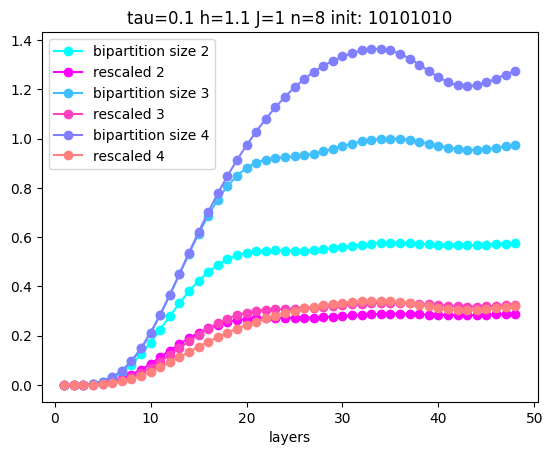

In [39]:
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, n//(2)+1)))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, n//(2)+1)))
leng= np.array([2,3,4],dtype=int)
layers = np.array([j for j in range(1,6*8+1)])

for m in range(1,n//(2)):
    color1 = next(color_cycle1)
    color2 = next(color_cycle2)
    plt.plot(layers, ent_entropy[m],'-o', c=color1,label='bipartition size '+str(m+1))
    plt.plot(layers, ent_entropy[m]/leng[m-1],'-o', c=color2,label='rescaled '+str(m+1))
    #plt.plot(layers, renyi[k],'-x', c=color1,label='Renyi n='+str(size))
    
plt.title('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(n)+' init: '+str(string))
plt.xlabel('layers')
plt.legend()   
    

In [18]:
#loading data
with open('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n=10', 'rb') as file:
    loaded_data = pickle.load(file)

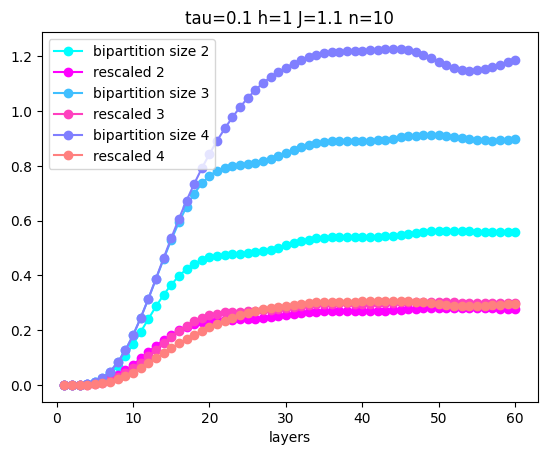

In [29]:
from itertools import cycle
colormap1 = plt.cm.cool
color_cycle1 = cycle(colormap1(np.linspace(0, 1, n//(2)+1)))
colormap2 = plt.cm.spring
color_cycle2 = cycle(colormap2(np.linspace(0, 1, n//(2)+1)))
leng= np.array([2,3,4],dtype=int)
layers = np.array([j for j in range(1,6*10+1)])

for m in range(1,n//(2)):
    color1 = next(color_cycle1)
    color2 = next(color_cycle2)
    plt.plot(layers, loaded_data[m],'-o', c=color1,label='bipartition size '+str(m+1))
    plt.plot(layers, loaded_data[m]/leng[m-1],'-o', c=color2,label='rescaled '+str(m+1))
    #plt.plot(layers, renyi[k],'-x', c=color1,label='Renyi n='+str(size))
#plt.axhline(y=np.log(2), color='g', linestyle='--', label='log(2) Line')    
plt.title('tau='+str(tau)+' h='+str(h)+' J='+str(J)+' n='+str(10))
plt.xlabel('layers')
plt.legend()   
    

In [8]:
#settings job execution
service = QiskitRuntimeService(channel="ibm_quantum")
options = Options()
options.execution.shots = 8000
options.optimization_level = 3  # optimization
options.resilience_level = 2  # mitigation

#coupling map for Simulator 
cmap = CouplingMap()
for i in range(n):
    if i == n-1:
        cmap.add_edge(n-1,0)
    else:
        cmap.add_edge(i, i + 1)
    

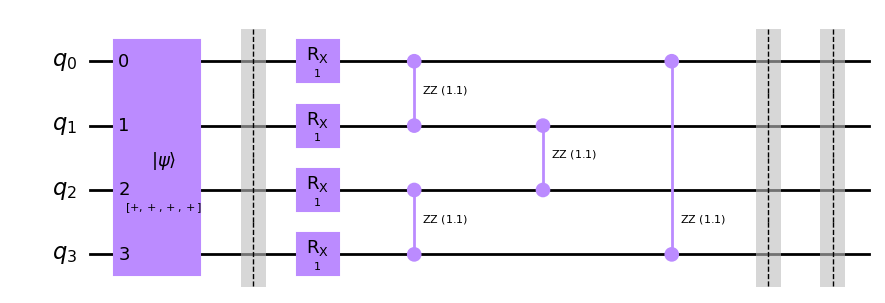

In [213]:
dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [168]:
from scipy.optimize import curve_fit


def my_curve_function(x, a):
    return 1/x**a

params, covariance = curve_fit(my_curve_function, distances, correlations, method='trf')

/home/alberto/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:626: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


100%|█████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:59<00:00, 42.81s/it]


Text(0.5, 1.0, 'TFIM Spatial Correlation $C_{ij}(r)$, h=1, J=1.1, layers=20')

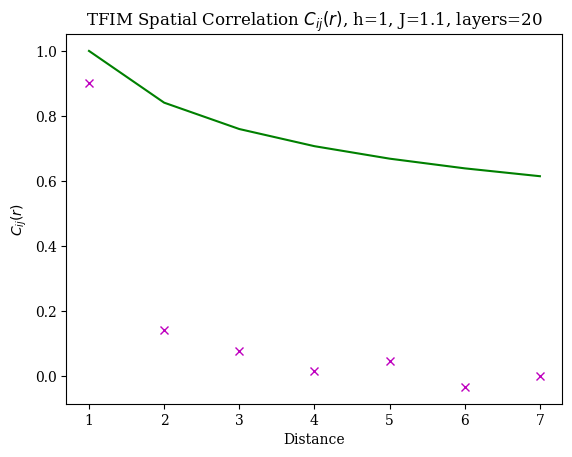

In [240]:
#computation of spatial correlation functions for incresing distance
correlations = np.zeros(n-1,dtype=complex)
for m in tqdm(range(1,n)):
    op1,op2,op3 = generate_pauli(n, 0, m)
    with Session(service=service, backend=backend) as session:
        estimator_sim = Estimator(session=session, options=options)
        job_sim = estimator_sim.run(circuits=[qcc]*3, observables=[op1,op2,op3], coupling_map=cmap)
        values = job_sim.result().values
        correlations[m-1]=2*values[0]-values[1]*values[2]
distances=np.array([i for i in range(1,8)], dtype=float)
plt.plot(distances, correlations,'x', c='m')
plt.plot(distances, 1/distances**(1/4),c='g')
plt.rcParams["font.family"] = "serif"
plt.xlabel(r'Distance')
plt.ylabel(r'$C_{ij}(r)$')
plt.title(r"TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J="+str(J)+", layers="+str(layers))
#plt.savefig("TFIM Spatial Correlation $C_{ij}(r)$, h="+str(h)+", J=1,1 , layers="+str(layers)+"op3mit2", bbox_inches='tight')

In [125]:
def generate_pauli(n, i, j):
    if n <= 0 or i < 0 or j < 0 or i >= n or j >= n:
        raise ValueError("Invalid input values")
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i and j
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op1 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position i
    pauli_str_list = list(pauli_str)
    pauli_str_list[i] = "Z"
    pauli_str = "".join(pauli_str_list)
    op2 = SparsePauliOp(pauli_str, coeffs=[1])
    
    pauli_str = "I" * n  # Initialize with n identity operators
    # Set the Z at position j
    pauli_str_list = list(pauli_str)
    pauli_str_list[j] = "Z"
    pauli_str = "".join(pauli_str_list)
    op3 = SparsePauliOp(pauli_str, coeffs=[1])

    

    return op1,op2,op3

In [212]:
#Circuit parameters
n=4
h=1
J=1.1
tau=0.1

layers=1
k=1
#Initialize qcirc and qstate
qc = QuantumCircuit(n)
QuantumCircuit.initialize(qc,'++++',[0,1,2,3])
sigma_z= np.array([[1,0],[0,-1]])
#prepare ancilla
#qc.h(0)
#creation of controlled unitary
#cu_gate = UnitaryGate(sigma_z, label='CU') #this gate will have to be the whole evolution circuit 

# Apply the controlled unitary operation with control qubit 0 and target qubit 1
#qc.append(cu_gate.control(), [0, 1])
qc.barrier(range(n))
#anti-controlled operation


m=0
while m<layers:
    for i in range(n):
        qc.rx(tau*h,i)
    for j in range(n//2):
        qc.rzz(tau*J, 2*j,2*j+1)
    for j in range(n//2):
        if j == (n//2 - 1):
                qc.rzz(tau*J, 2*j+1,0)
                break
        qc.rzz(tau*J, 2*j+1,2*j+2)
    qc.barrier(range(n))
    m+=1
    
    
#anti_gate = cu_gate.control(ctrl_state='0')
#qc.append(anti_gate, [0, j+1])
qc.barrier(range(n))

basis_gates=['cx', 'id', 'rz', 'x', 'sx']
qcc=transpile(qc, basis_gates=basis_gates, optimization_level=3)